<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Lendo-Dados" data-toc-modified-id="Lendo-Dados-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Lendo Dados</a></span></li><li><span><a href="#Dados-Nulos" data-toc-modified-id="Dados-Nulos-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Dados Nulos</a></span></li><li><span><a href="#Separando-Dados" data-toc-modified-id="Separando-Dados-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Separando Dados</a></span></li><li><span><a href="#Pipeline" data-toc-modified-id="Pipeline-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Pipeline</a></span></li><li><span><a href="#Avaliando-Resultados" data-toc-modified-id="Avaliando-Resultados-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Avaliando Resultados</a></span><ul class="toc-item"><li><span><a href="#Regressão-Logística" data-toc-modified-id="Regressão-Logística-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Regressão Logística</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Multi-Layer-Perceptron" data-toc-modified-id="Multi-Layer-Perceptron-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Multi Layer Perceptron</a></span></li></ul></li><li><span><a href="#Dados-de-Teste" data-toc-modified-id="Dados-de-Teste-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Dados de Teste</a></span></li></ul></div>

Nesta segunda versão do algoritmo, vamos investigar melhorias para aumentar a performance do modelo obtido com análises primárias. O objetivo é encontrar uma acurácia que supere um valor de 80%.

## Lendo Dados

In [1]:
# Importando biblioteca pandas e lendo arquivo
import pandas as pd

df = pd.read_csv('german_credit_data.csv', index_col=0)
df.head(5)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


In [2]:
# Acertando nome das colunas
df.columns = [col.replace(' ', '_').lower() for col in df.columns]
df.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## Dados Nulos

Um dos primeiros pontos investigativos se basea no treinamento de um modelo, tendo as colunas `checking_account` e `saving_accounts` como target, para preencher os dados nulos destas mesmas colunas.

In [3]:
# Pipeline para treinar dados de checking_account
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

# Preparando pipeline
num_attribs_cc = ['age', 'credit_amount', 'duration']
cat_attribs_cc = ['sex', 'job', 'housing', 'purpose', 'risk']

# Criando pipeline numérico
num_pipeline_cc = Pipeline([
    ('std_scaler', StandardScaler())
])

# Criando pipeline categórico
cat_pipeline_cc = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False))
])

# Definindo pipeline completo
full_pipeline_cc = ColumnTransformer([
    ('num_pipeline', num_pipeline_cc, num_attribs_cc),
    ('cat_pipeline', cat_pipeline_cc, cat_attribs_cc)
])

In [4]:
# Pipeline para treinar dados de saving_accounts

# Preparando pipeline
num_attribs_cp = ['age', 'credit_amount', 'duration']
cat_attribs_cp = ['sex', 'job', 'housing', 'purpose', 'risk', 'checking_account']

# Criando pipeline numérico
num_pipeline_cp = Pipeline([
    ('std_scaler', StandardScaler())
])

# Criando pipeline categórico
cat_pipeline_cp = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False))
])

# Definindo pipeline completo
full_pipeline_cp = ColumnTransformer([
    ('num_pipeline', num_pipeline_cp, num_attribs_cp),
    ('cat_pipeline', cat_pipeline_cp, cat_attribs_cp)
])

In [5]:
# Definindo uma classe
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neural_network import MLPClassifier

class FillCheckingAcc(BaseEstimator, TransformerMixin):
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        
        # Definindo features checking_account
        features_cc = ['age', 'sex', 'job', 'housing', 'credit_amount', 'duration', 
                       'purpose', 'risk']
        label_cc = ['checking_account']
        
        # Indexando dados de CC
        X_cc_notnull = df[df['checking_account'].notnull()]
        X_cc_null = df[df['checking_account'].isnull()]
        X_train_cc = X_cc_notnull.loc[:, features_cc]
        y_train_cc = X_cc_notnull.loc[:, label_cc]
        X_fill_cc = X_cc_null.loc[:, features_cc]
        
        # Preparando dados
        X_cc_prepared = full_pipeline_cc.fit_transform(X_train_cc)
        X_cc_fill_prepared = full_pipeline_cc.fit_transform(X_fill_cc)
       
        # Treinando modelo e predizendo (checking_account)
        mlp_clf_cc = MLPClassifier()
        mlp_clf_cc.fit(X_cc_prepared, y_train_cc)
        cc_pred = mlp_clf_cc.predict(X_cc_fill_prepared)
        X_cc_null['checking_account'] = cc_pred
        
        return pd.concat([X_cc_notnull, X_cc_null])

In [6]:
# Preenchendo dados nulos de checking_account
import warnings
warnings.filterwarnings('ignore')

filler_checking_account = FillCheckingAcc()
df_full_cc = filler_checking_account.fit_transform(df)

In [7]:
# Verificando
df_full_cc.isnull().sum()

age                   0
sex                   0
job                   0
housing               0
saving_accounts     183
checking_account      0
credit_amount         0
duration              0
purpose               0
risk                  0
dtype: int64

Deu certo! Vamos treinar o modelo para preencher os dados nulos em `saving_accounts`.

In [8]:
# Definindo uma classe
class FillSavingAcc(BaseEstimator, TransformerMixin):
    
    def fit(self, df, y=None):
        return self
    
    def transform(self, df, y=None):
        
        # Definindo features checking_account
        features_cp = ['age', 'sex', 'job', 'housing', 'credit_amount', 'duration', 
                       'purpose', 'risk', 'checking_account']
        label_cp = ['saving_accounts']
        
        # Indexando dados de CC
        X_cp_notnull = df[df['saving_accounts'].notnull()]
        X_cp_null = df[df['saving_accounts'].isnull()]
        X_train_cp = X_cp_notnull.loc[:, features_cp]
        y_train_cp = X_cp_notnull.loc[:, label_cp]
        X_fill_cp = X_cp_null.loc[:, features_cp]
        
        # Preparando dados
        X_cp_prepared = full_pipeline_cp.fit_transform(X_train_cp)
        X_cp_fill_prepared = full_pipeline_cp.fit_transform(X_fill_cp)
       
        # Treinando modelo e predizendo (checking_account)
        mlp_clf_cp = MLPClassifier()
        mlp_clf_cp.fit(X_cp_prepared, y_train_cp)
        cp_pred = mlp_clf_cp.predict(X_cp_fill_prepared)
        X_cp_null['saving_accounts'] = cp_pred
        
        return pd.concat([X_cp_notnull, X_cp_null])

In [9]:
# Testando
filler_saving_accouns = FillSavingAcc()
df_full_complete = filler_saving_accouns.fit_transform(df_full_cc)

In [10]:
# Verificando
df_full_complete.isnull().sum()

age                 0
sex                 0
job                 0
housing             0
saving_accounts     0
checking_account    0
credit_amount       0
duration            0
purpose             0
risk                0
dtype: int64

In [11]:
# Vejamos primeiras linhas
df_full_complete.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose,risk
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad
7,35,male,3,rent,little,moderate,6948,36,car,good
9,28,male,3,own,little,moderate,5234,30,car,bad


In [12]:
# Nova condição do atributo checking_account
df_full_complete['checking_account'].value_counts()

moderate    512
little      408
rich         80
Name: checking_account, dtype: int64

In [13]:
# Nova condição do atributo saving_accounts
df_full_complete['saving_accounts'].value_counts()

little        777
moderate      111
quite rich     64
rich           48
Name: saving_accounts, dtype: int64

## Separando Dados

In [14]:
# Importando módulo
from sklearn.model_selection import train_test_split

# Selecionando dados
X = df_full_complete.iloc[:, :9]
y = df_full_complete.iloc[:, -1]

# Transformando label em 0s e 1s
y = (y == 'bad')*1

In [15]:
# Verificnado
X.head()

,age,sex,job,housing,saving_accounts,checking_account,credit_amount,duration,purpose
1,22,female,2,own,little,moderate,5951,48,radio/TV
3,45,male,2,free,little,little,7882,42,furniture/equipment
4,53,male,2,free,little,little,4870,24,car
7,35,male,3,rent,little,moderate,6948,36,car
9,28,male,3,own,little,moderate,5234,30,car


In [16]:
# Label
y.head()

1    1
3    0
4    1
7    0
9    1
Name: risk, dtype: int32

In [17]:
# Separando dados
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20)

# Verificando
print(f'Dimensões de X_train: {X_train.shape}')
print(f'Dimensões de X_test: {X_test.shape}')
print(f'\nDimensões de y_train: {y_train.shape}')
print(f'Dimensões de y_test: {y_test.shape}')

Dimensões de X_train: (800, 9)
Dimensões de X_test: (200, 9)

Dimensões de y_train: (800,)
Dimensões de y_test: (200,)


In [18]:
# Verificando distribuição
y_train.value_counts()

0    564
1    236
Name: risk, dtype: int64

In [19]:
# Distribuição de teste
y_test.value_counts()

0    136
1     64
Name: risk, dtype: int64

In [20]:
# Distribuição das colunas recém imputadas
X_train['checking_account'].value_counts()

moderate    416
little      326
rich         58
Name: checking_account, dtype: int64

In [21]:
# saving_accounts
X_train['saving_accounts'].value_counts()

little        613
moderate       94
quite rich     53
rich           40
Name: saving_accounts, dtype: int64

Suspeita: coluna `saving_accounts` é pouca representativa para o modelo, dado que temos muitos dados com uma única classificação.

## Pipeline

In [22]:
# Importando módulo especial do scikit para unir pipelines
from sklearn.compose import ColumnTransformer

# Preparando pipeline
num_attribs = ['age', 'credit_amount', 'duration']
cat_attribs = ['sex', 'job', 'housing', 'saving_accounts', 
               'checking_account', 'purpose']

# Criando pipeline numérico
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

# Criando pipeline categórico
cat_pipeline = Pipeline([
    ('one_hot', OneHotEncoder(sparse=False))
])

# Definindo pipeline completo
full_pipeline = ColumnTransformer([
    ('num_pipeline', num_pipeline, num_attribs),
    ('cat_pipeline', cat_pipeline, cat_attribs)
])

# Dados preparados
X_train_prepared = full_pipeline.fit_transform(X_train)

## Avaliando Resultados

In [23]:
# Importando bibliotecas
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

In [24]:
# Função para plotagem da curva ROC
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()

In [25]:
# Definindo função para retornar toda a análise nos dados de treino
def full_train_analysis(model, X, y, acc=True, cross_val=True, cv=5, precision=True, 
                        recall=True, f1=True, conf_mx=True, roc=True):
    
    # Calculando requisitos para as análises
    flag_tree = False
    y_pred = model.predict(X)
    y_scores = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    y_cfmx_pred = cross_val_predict(model, X, y, cv=cv)
    
    try:
        y_roc_pred = cross_val_predict(model, X, y, cv=5, method='decision_function')
    except:
        # Decision Trees e Random Forest não possuem decision_function
        y_probas = cross_val_predict(model, X, y, cv=5, method='predict_proba')
        y_scores_tree = y_probas[:, 1]
        flag_tree = True
    
    # Retornando análise
    if acc:
        accuracy = accuracy_score(y_pred, y)
        print(f'Acurácia do modelo: {accuracy:.2f}')
    if cross_val:
        print(f'\nCross Validation: {y_scores}')
    if precision:
        p_score = precision_score(y, y_pred)
        print(f'\nPrecision: {p_score:.2f}')
    if recall:
        r_score = recall_score(y, y_pred)
        print(f'\nRecall: {r_score:.2f}')
    if f1:
        f_score = f1_score(y, y_pred)
        print(f'\nf1_score: {f_score:.2f}')
    if conf_mx:
        matriz = confusion_matrix(y, y_cfmx_pred)
        print(f'\nMatriz de Confusão: \n{matriz}')
    if roc:
        if flag_tree:
            fpr, tpr, thresholds = roc_curve(y, y_scores_tree)
        else:
            fpr, tpr, thresholds = roc_curve(y, y_roc_pred)
        plot_roc_curve(fpr, tpr)

### Regressão Logística

Acurácia do modelo: 0.73

Cross Validation: [0.7515528  0.71875    0.68125    0.71875    0.67924528]

Precision: 0.59

Recall: 0.24

f1_score: 0.34

Matriz de Confusão: 
[[518  46]
 [186  50]]


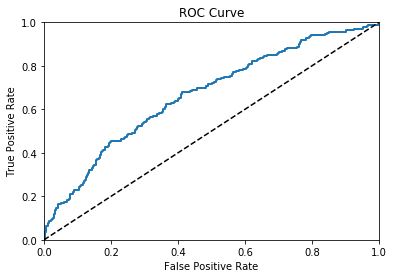

In [26]:
# Treinando modelo de Regressão Logística e verificando resultados
log_reg = LogisticRegression()
log_reg.fit(X_train_prepared, y_train)

full_train_analysis(log_reg, X_train_prepared, y_train)

### Random Forest

Acurácia do modelo: 0.98

Cross Validation: [0.67701863 0.68125    0.64375    0.7375     0.67924528]

Precision: 1.00

Recall: 0.94

f1_score: 0.97

Matriz de Confusão: 
[[497  67]
 [171  65]]


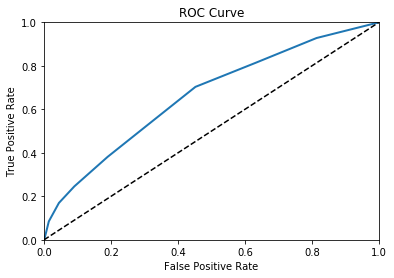

In [27]:
# Treinando modelo
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(X_train_prepared, y_train)
full_train_analysis(forest_clf, X_train_prepared, y_train)

### Multi Layer Perceptron

Acurácia do modelo: 0.84

Cross Validation: [0.78881988 0.73125    0.7375     0.70625    0.72955975]

Precision: 0.81

Recall: 0.61

f1_score: 0.70

Matriz de Confusão: 
[[494  70]
 [153  83]]


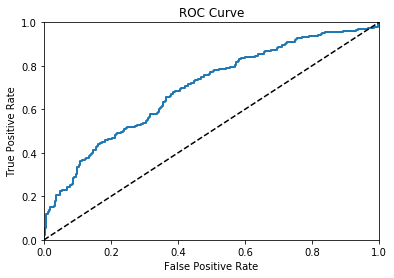

In [28]:
# Treinando modelo
from sklearn.neural_network import MLPClassifier

mlp_clf = MLPClassifier()
mlp_clf.fit(X_train_prepared, y_train)
full_train_analysis(mlp_clf, X_train_prepared, y_train)

## Dados de Teste

In [30]:
# Preparando dados
X_test_prepared = full_pipeline.fit_transform(X_test)
y_pred = mlp_clf.predict(X_test_prepared)
accuracy_score(y_pred, y_test)

0.685

In [31]:
y_pred = forest_clf.predict(X_test_prepared)
accuracy_score(y_pred, y_test)

0.7

In [32]:
y_pred = log_reg.predict(X_test_prepared)
accuracy_score(y_pred, y_test)

0.715